# 1. Function Approximation

We want to approximate a function with two inputs and one output.
This function can be interpreted as 3-dimensional plot $t=f(x_1,x_2)$.
We first provide a plotting function to visualize the data and the resulting network output.

In [1]:
import torch
from matplotlib import pyplot
import numpy

# a plotting function to show the data and the result
def plot_3d(X, Y, Z):
  f = pyplot.figure(figsize=(5,14))
  ax = f.add_subplot(121, projection='3d', azim = -90, elev=90)
  ax.plot_surface(X,Y,Z, cmap="hot", alpha=.8)
  ax.set_xlabel("$x_1$")
  ax.set_ylabel("$x_2$")
  ax.set_zlabel("$t$")

  ax = f.add_subplot(122, projection='3d', azim = -60, elev=30)
  ax.plot_surface(X,Y,Z, cmap="hot", alpha=.8)
  ax.set_zlim(-1,1)
  ax.set_xlabel("$x_1$")
  ax.set_ylabel("$x_2$")
  ax.set_zlabel("$t$")

Now, we define our original data. This is just for visualization purposes, you do not have to modify this.

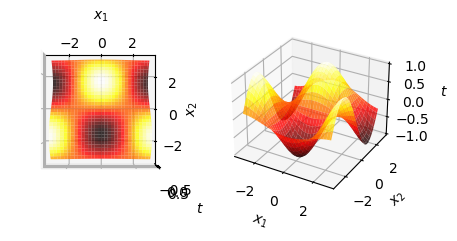

In [2]:
# our data function that takes two parameters, x_1 and x_2
def data(x_1, x_2):
  return torch.cos(x_1) * torch.sin(x_2)

# display our function in a three-dimensional range
rge = numpy.arange(-3,3,0.1)
X,Y = numpy.meshgrid(rge, rge)
Z = data(torch.tensor(X), torch.tensor(Y)).numpy()
plot_3d(X, Y, Z)

### 1. (e) Autograd Function

We want to implement the gradient that we have computed in (b) as a `torch.autograd.Function`.
Remember that the output of the `backward` function are the gradients with respect to all input parameters of the `forward` function. 

In [49]:
import numpy as np
from torch._C import wait
class MyFunction(torch.autograd.Function):

  # implement the forward propagation
  @staticmethod
  def forward(ctx, x, w):
    # compute the output
    output = x * w
    # save required parameters for backward pass
    ctx.save_for_backward(x, w)
    return output.T

  # implement Jacobian
  @staticmethod
  def backward(ctx, grad):
    # get results stored from forward pass
    x, w = ctx.saved_tensors

    da_dw = x
    
    # compute the derivatives
    grad_w = torch.Tensor(np.outer(grad, da_dw))
    return grad_w, None


### 1. (f) Network Implementation

We implement our network to combine the first layer with an activation function, and a fully-connected layer to produce our desired output.

In [50]:
class Network(torch.nn.Module):
  def __init__(self, K, D):
    super(Network, self).__init__()
    # we select our function defined above as the first layer that we apply
    self.layer1 = MyFunction.apply
    

    # We need to instantiate and initialize our weights
    self.W = torch.nn.Parameter(torch.empty((K,D)))
    # initialize the matrix between -3 and 3 (since the range of the inputs is (-3,3))
    torch.nn.init.uniform_(self.W, -3, 3)

    # We then instantiate the second fully-connected layer
    self.layer2 = torch.nn.Linear(K, 1)

    # anything else to instantiate here?
    self.activation = torch.nn.Tanh()
    

  def forward(self, x):
    # forward input through our custom function
    x = self.layer1(x, self.W)
    
    # possibly apply an activation function
    x = self.activation(x)
  
    # apply second layer
    x = self.layer2(x)

    return x

# instantiate a network with the desired parameters
network = Network(10, 2)

We implement a function that draws random samples from the input distribution.
You can make use of this function, there is no need to modify it.

In [51]:
# provides a sample from the function that we want to approximate
def sample():
  # get a random input
  x = torch.rand(2) * 6 - 3
  # compute the target
  t = data(x[0], x[1])[None]
  # return both
  return x, t

### 1. (g) Network Training

Finally, we train our network on 100000 samples, using a batch size of 1. We report the average loss for 10000 samples once they are processed.

In [54]:
# instantiate loss function and optimizer
loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

#create variable to store train loss
train_loss = 0

# iterate over 100000 samples
for i in range(100000):
  # obtain a sample
  x, t = sample()
  # train the network with this sample
  optimizer.zero_grad()
  y = network(x)

  # ... compute loss from network output and target data
  J = loss(y, t)
  
  # ... perform parameter update
  J.backward()
  optimizer.step()
  
  # ... remember loss
  train_loss += J.item()

  # compute average loss
  avg_loss = train_loss / (i+1)
  
  # report it after every 10000 iterations
  if i % 10000 == 9999:
    print("Iteration {}: average loss {}".format(i+1, avg_loss))

Iteration 10000: average loss 0.25869528853209284
Iteration 20000: average loss 0.260260748232459
Iteration 30000: average loss 0.25977517241504566
Iteration 40000: average loss 0.25987556546043633
Iteration 50000: average loss 0.26064963253183554
Iteration 60000: average loss 0.26012052065397157
Iteration 70000: average loss 0.2600693793498148
Iteration 80000: average loss 0.2599426688615503
Iteration 90000: average loss 0.2595685343901653
Iteration 100000: average loss 0.25951958561872784


Finally, we plot the output of your network to visually see whether the data has been approximated well.
We actually extend the range of the input samples to be $[-5,5]$ to see if the network has learned to extend the function well beyond the training range.
Note that this is just for visualization purposes, you do not need to change this part.

In [ ]:
# define a range a little larger than our input range
rge = numpy.arange(-5,5,0.1)
X,Y = numpy.meshgrid(rge, rge)
# compute the result of our network for the given range [-5,5]x[-5,5]
Z = numpy.array([[network(torch.FloatTensor((X[i,j], Y[i,j]))).item() for j in range(len(rge))] for i in range(len(rge))])
# plot the results
plot_3d(X,Y,Z)